### Implementación del  método de hidrodinámica de partículas suavizadas (SPH) para la simulacion  de una  supernova
 Fundacion universitaria konrad Lorenz \\
 Computacion cientifica II \\
 Nataly Phawllyn Neira Parra

##Librerias y otros

In [1]:
import numexpr as ne
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.integrate import solve_ivp
from scipy.spatial.distance import cdist
import multiprocessing as mp
from scipy.stats import norm
from multiprocessing import Pool
from IPython.display import Image

##  Condiciones iniciales

Se  preparan  dos  conjuntos de con diciones iniciales  el primero  para  una  simula ción simple  con   valores   considerables pero no especificos para  una  simulación real,  El segundo se usan los  valores de las  constantes  reales  y se intenta aproximar las condiciones iniciales  a las  reales  en el ambito  astronomico.

In [2]:
# Constantes  para simulaciones de prueba
G = 50.0                  # Constante  gravitacional
NUM_PARTICLES = 1000
TIME_STEP = 0.001
NUM_STEPS = 1000
PARTICLE_MASS = 0.01      # masa de cada  particula
SOFTENING = 0.01          #  factor  de suavidad para el calculo de distancias
KERNEL_RADIUS = 0.5       #  radio del  kernel para  la  distribución de densidad
R_GAS_CONSTANT = 0.1      # Constante de los Gases
TEMPERATURE = 0.1         # Temperatura
VISCOSITY = 0.01          # Coeficiente de  viscosidad

#  Inciciacón de las particulas  en una distribución esferica

radius = 1.0  # radio  inicial de la estrella
positions = np.random.normal(0, radius / 3, (NUM_PARTICLES, 3))  #  se distribuye   gaussina
positions = positions / np.linalg.norm(positions, axis=1).reshape(-1, 1) * np.random.uniform(0, radius, NUM_PARTICLES).reshape(-1, 1)

# Inicializacion de  propiedades
velocities = -0.05 * positions / np.linalg.norm(positions, axis=1).reshape(-1, 1)
densities = np.zeros(NUM_PARTICLES)
pressures = np.zeros(NUM_PARTICLES)
densities_over_time=[]

In [ ]:
# constantes  para  la muerte  de una  estrella  tipo  super nova
G = 39.478                  #UA^3MS^-1yr^-2   constante  gravitacional
NUM_PARTICLES = 1000        #10 MS
TIME_STEP = 1E-4            # yr
NUM_STEPS = int(1E3)        #  mas pasos  implica mas  tiempo
PARTICLE_MASS = 0.01        #MS  MS:= masas  solares
SOFTENING = 0.01
KERNEL_RADIUS = 0.2
R_GAS_CONSTANT = 8.314E-7   # mol^-1K^-1  constante de los  gases para altas  temperaturas
TEMPERATURE = 1E9           # K  temperatura  estandar del  nucleo
VISCOSITY =0.5              #  constante de viscosidad

# Inciciacón de las particulas  en una distribución esferica

radius = 1.0  # Radio inicial en UA
positions = np.random.normal(0, radius / 3, (NUM_PARTICLES, 3))
positions *= np.random.uniform(0, radius, NUM_PARTICLES).reshape(-1, 1) / np.linalg.norm(positions, axis=1).reshape(-1, 1)

# Inicializacion de  propiedades

inward_velocity = -0.01  # Relativamente baja en unidades AU/yr
velocities = inward_velocity * positions / np.linalg.norm(positions, axis=1).reshape(-1, 1)

densities = PARTICLE_MASS / (4 / 3 * np.pi * radius**3)  # Estrella esférica uniforme
pressures = R_GAS_CONSTANT * densities * TEMPERATURE     # ley  ideal  de los  gases


## funciones de  ejecución

### funciones  de implementación SPH
 definicion del kernel  con una  distribucion  normal \\
 calculo de  la densidad  por  particula

In [3]:
def gaussian_kernel(r, h=KERNEL_RADIUS):
    """SPH funcion de Kernel Gaussiano."""
    return norm.pdf(r, scale=h) / h

def compute_densities():
    """Calcula la densidad d e las  particulas  deacuerdo con las particulas  vecinas  usando SPH   con  kernel Gausiano."""
    global densities
    print("calculando densidad")
    distances = cdist(positions, positions)  # tamaño (N, N)  # distancia entre pares de particulas
    kernel_values = gaussian_kernel(distances, KERNEL_RADIUS)
    np.fill_diagonal(kernel_values, 0)  # no interaccion consigo misma
    densities = PARTICLE_MASS * np.sum(kernel_values, axis=1)
    densities_over_time.append(densities.copy())


### Funciones para discretizar
 Todos los calculos  están  en  funcion de la distancia  entre pares de particulas \\
 presión  del gas \\
 fuerza de viscosidad \\
 fuerza de  gravedad \\

Implementacion de la ecuacion de Navier- Stokes en el calculo de las  fuerzas  totales.

In [4]:
def Pairwise_distance_vectors():
    """Calcula los vectores de distancia entre pares de particulas."""
    global r_vec, distances
    a=positions[:, np.newaxis, :]
    b=positions[np.newaxis, :, :]
    r_vec = ne.evaluate("a- b")  # tamaño: (N, N, 3)
    distances = np.linalg.norm(r_vec, axis=2) + SOFTENING  #  (N, N)
    np.fill_diagonal(distances, np.inf)
    print("calculando distancia  entre pares")


def compute_pressures():
    """Calcula la  presion de  cada particula  usando la ley de los  gases ideales ."""
    global pressures
    pressures = densities * R_GAS_CONSTANT * TEMPERATURE
    print("calculando presion ley ideal de los gases")
    #epsilon = 1e-10  # Pequeño valor para evitar divisiones por cero
    #pressures[densities <= epsilon] = 0  # Establece la presión a 0 si la densidad es muy baja


def compute_pressure_forces():
    """Calcula  la  fuerza de la  presion usando el  gradiente de  SPH"""
    pressure_forces = np.zeros((NUM_PARTICLES, 3))   # inicializa
    Pairwise_distance_vectors()
    print("calculando presion usando el  gradiente de  SPH")
    # calculo gradiente por pares de particulas
    kernel_values = gaussian_kernel(distances, KERNEL_RADIUS)[..., np.newaxis]  #  (N, N, 1)
    c=distances[..., np.newaxis]
    kernel_gradient = ne.evaluate("-kernel_values * r_vec / c") #  (N, N, 3)

    # Calculo y suma de las  presiones
    epsilon = 1e-10    # epsilon para evitar divisiones en  cero
    for i in range(NUM_PARTICLES):
        # Calculate pressure force based on SPH formula for each particle
        pressure_contrib =PARTICLE_MASS * (pressures[i] /(densities[i]*2+ epsilon) + pressures / (densities*2 + epsilon))
        pressure_forces[i] = np.sum(pressure_contrib[:, np.newaxis] * kernel_gradient[i], axis=0)

    return pressure_forces


def compute_viscous_forces():
    """Calcula  la  fuerza de la viscosidad  basado en la  velocidad de las particulas( simple Navier-Stokes)"""
    viscous_forces = np.zeros((NUM_PARTICLES, 3))
    Pairwise_distance_vectors()
    print("calculando fuerza de viscosidad")

    # velocidad relativa entre particulas
    a1=velocities[:, np.newaxis, :]
    b1=velocities[np.newaxis, :, :]
    rel_velocities = ne.evaluate("a1 - b1")
    c1=distances[..., np.newaxis]
    viscous_term = ne.evaluate("VISCOSITY * (rel_velocities / (c1 + SOFTENING)**2)")
    viscous_forces = np.sum(viscous_term, axis=1) * PARTICLE_MASS

    return viscous_forces

def compute_gravitational_forces():
    """Calcula  la  fuerza  gravitacional por  pares de particulas."""
    Pairwise_distance_vectors()
    print("calculando fuerza de gravedad")
    d1=distances[:, :, np.newaxis]
    grav_forces =ne.evaluate("G * PARTICLE_MASS**2 * r_vec / d1**3")
    net_grav_forces = np.sum(grav_forces, axis=1)

    return net_grav_forces

def compute_total_forces():
    """Calcula  la  fuerza  total sobre cada particula  (presión , viscosidad  y gravedad)."""
   # Uso de computación en Paralelo
    with Pool(3) as pool:
        pressure_forces = pool.apply_async(compute_pressure_forces).get()
        viscous_forces = pool.apply_async(compute_viscous_forces).get()
        gravitational_forces = pool.apply_async(compute_gravitational_forces).get()

    total_forces = pressure_forces + viscous_forces + gravitational_forces
    print("se sumo las  fuerzas, despues del paralelo")
    return total_forces

### Sistema de ecuaciones diferencial
 ecuacion diferencial  que describe el comportamiento del  fluido


In [5]:
def derivatives_supernova(t, y):
    """Calcula  la  derivada  o aceleracion de cada  particula  en los pasos  temporales  de la simulacion.
    ENTRADAS:
      y[array] =   posicion  y velocidad  3D de cada particula  de la  forma [x1, y1, z1, vx1, vy1, vz1, x2, y2, z2, vx2, vy2, vz2, ...]
      t[float] =   Salto temporal
    SALIDAS:
      dydt[array] =  aceleracion de cada particula de la forma [ax1, ay1, az1, ax2, ay2, az2, ...]
    """
    global positions, velocities
    pos = y[:NUM_PARTICLES * 3].reshape((NUM_PARTICLES, 3))
    vel = y[NUM_PARTICLES * 3:].reshape((NUM_PARTICLES, 3))

    positions, velocities = pos, vel  # Se actualiza las posiciones  y velocidades globales para el calculo de las densidades

    print("calculando la aceleración - inicio")
    # Calculo de las  fuerzas  en ese  punto temporal
    compute_densities()
    compute_pressures()
    accelerations = compute_total_forces() / PARTICLE_MASS

    #  inicio de la exploción
    explosion_time = NUM_STEPS * TIME_STEP / 2   # inicio de la explosión

    if t > explosion_time:
        # aplica aceleraciones  proporcionales a las densidades
        radial_directions = positions / np.linalg.norm(positions, axis=1).reshape(-1, 1)
        explosion_strength = 50.0 * (densities / densities.max())  # Scale based on density
        e1=explosion_strength[:, np.newaxis]
        accelerations += ne.evaluate("e1 * radial_directions")

    print("calculando la aceleración - final")
    dydt = np.concatenate([vel.flatten(), accelerations.flatten()])
    return dydt


## Cálculo numérico de la solución

In [6]:
# PVI  solver
initial_conditions = np.concatenate([positions.flatten(), velocities.flatten()])
solution = solve_ivp(derivatives_supernova, [0, NUM_STEPS * TIME_STEP], initial_conditions, method='RK45', t_eval=np.linspace(0, NUM_STEPS * TIME_STEP, NUM_STEPS))

calculando la aceleración - inicio
calculando densidad
calculando presion ley ideal de los gases
calculando distancia  entre pares
calculando presion usando el  gradiente de  SPH
calculando distancia  entre pares
calculando fuerza de viscosidad
calculando distancia  entre pares
calculando fuerza de gravedad
se sumo las  fuerzas, despues del paralelo
calculando la aceleración - final
calculando la aceleración - inicio
calculando densidad
calculando presion ley ideal de los gases
calculando distancia  entre pares
calculando presion usando el  gradiente de  SPH
calculando distancia  entre pares
calculando fuerza de viscosidad
calculando distancia  entre pares
calculando fuerza de gravedad
se sumo las  fuerzas, despues del paralelo
calculando la aceleración - final
calculando la aceleración - inicio
calculando densidad
calculando presion ley ideal de los gases
calculando distancia  entre pares
calculando presion usando el  gradiente de  SPH
calculando distancia  entre pares
calculando fuer

actualizacion de  las posicion y velocidad

In [7]:
#  extracció de la solución , posición y  velocidad
positions_over_time = solution.y[:NUM_PARTICLES * 3].reshape((NUM_PARTICLES, 3, -1))
velocities_over_time = solution.y[NUM_PARTICLES * 3:].reshape((NUM_PARTICLES, 3, -1))
densities_over_time=np.array(densities_over_time)


# Visualizacion  gif

 ### gif frame  ajustable

In [ ]:
# Configuración de la visualización en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# Número de fotogramas y tiempo por fotograma
num_frames = positions_over_time.shape[2]
time_per_frame = 0.08  # Tiempo por fotograma en segundos

# Inicializa la variable de la barra de color
scatter = None
cbar = None

# Crear la función para actualizar cada fotograma
def update(frame):
    global scatter, cbar
    ax.clear()

    # Calcular las posiciones de las partículas en el fotograma actual
    positions = positions_over_time[:, :, frame]

    # Calcular la distancia máxima desde el centro
    distances = np.linalg.norm(positions, axis=1)
    max_distance = np.max(distances)

    # Ajustar los límites del gráfico 3D según la distancia máxima
    margin = 0.1  # Margen adicional para evitar que las partículas se peguen a los límites
    ax.set_xlim([-max_distance * (1 + margin), max_distance * (1 + margin)])
    ax.set_ylim([-max_distance * (1 + margin), max_distance * (1 + margin)])
    ax.set_zlim([-max_distance * (1 + margin), max_distance * (1 + margin)])

    ax.set_xlabel("X (AU)")
    ax.set_ylabel("Y (AU)")
    ax.set_zlabel("Z (AU)")


    # Calcular velocidades y magnitud de la velocidad
    velocities = velocities_over_time[:, :, frame]
    speed = np.linalg.norm(velocities, axis=1)

    # Escala de color basada en la velocidad
    scatter = ax.scatter(
        positions[:, 0],
        positions[:, 1],
        positions[:, 2],
        s=5,
        c=speed,
        cmap='plasma',
    )

    # Crear la barra de color solo una vez
    if cbar is None:
        cbar = fig.colorbar(scatter, ax=ax, shrink=0.7)
        cbar.set_label("Velocidad (AU/yr)")

    # Mostrar el tiempo de simulación
    time = frame * time_per_frame
    ax.text2D(0.05, 0.95, f"Tiempo: {time:.2f} s", transform=ax.transAxes, fontsize=12, color='black')

# Crear la animación
ani = FuncAnimation(fig, update, frames=num_frames, interval=50)

# Guardar el GIF
writer = PillowWriter(fps=20)
ani.save("sph_simulation.gif", writer=writer)

# Mostrar el GIF
Image(open("sph_simulation.gif", 'rb').read())


Output hidden; open in https://colab.research.google.com to view.

 ### gif frame  fijo

In [ ]:
# Configuración de la visualización en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Número de fotogramas y tiempo por fotograma
num_frames = positions_over_time.shape[2]
time_per_frame = 0.08  # Tiempo por fotograma en segundos

# Inicializa la variable de la barra de color
scatter = None
cbar = None

# Crear la función para actualizar cada fotograma
def update(frame):
    global scatter, cbar
    ax.clear()
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)

    ax.set_xlabel("X (AU)")
    ax.set_ylabel("Y (AU)")
    ax.set_zlabel("Z (AU)")


    # Calcular velocidades y magnitud de la velocidad
    velocities = velocities_over_time[:, :, frame]
    speed = np.linalg.norm(velocities, axis=1)

    # Escala de color basada en la velocidad
    scatter = ax.scatter(
        positions_over_time[:, 0, frame],
        positions_over_time[:, 1, frame],
        positions_over_time[:, 2, frame],
        s=5,
        c=speed,
        cmap='plasma',
    )

    # Crear la barra de color solo una vez
    if cbar is None:
        cbar = fig.colorbar(scatter, ax=ax, shrink=0.7)
        cbar.set_label("Velocidad (AU/yr)")

    # Mostrar el tiempo de simulación
    time = frame * time_per_frame
    ax.text2D(0.05, 0.95, f"Tiempo: {time:.2f} s", transform=ax.transAxes, fontsize=12, color='black')

ani = FuncAnimation(fig, update, frames=num_frames, interval=50)

# Guardar el GIF
writer = PillowWriter(fps=20)
ani.save("sph_simulation.gif", writer=writer)

# Mostrar el GIF
from IPython.display import Image
Image(open("sph_simulation.gif", 'rb').read())


Output hidden; open in https://colab.research.google.com to view.

##gif con radio  kernel

In [8]:
# Configuración de la visualización en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Parámetros de la simulación
GRID_RESOLUTION = 50  # Resolución del volumen 3D
num_frames = int(positions_over_time.shape[2]/4)
time_per_frame = 0.08  # Tiempo por fotograma en segundos

# Crear una malla tridimensional para calcular el mapa de densidad
x = np.linspace(-1, 1, GRID_RESOLUTION)
y = np.linspace(-1, 1, GRID_RESOLUTION)
z = np.linspace(-1, 1, GRID_RESOLUTION)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')  # 'ij' asegura el orden correcto de los ejes

scatter = None
# Crear la función para actualizar cada fotograma
def update(frame):
    global scatter
    ax.clear()
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_zlim(-4, 4)

    ax.set_xlabel("X (AU)")
    ax.set_ylabel("Y (AU)")
    ax.set_zlabel("Z (AU)")

    # Calcular densidad volumétrica
    density_field = np.zeros(X.shape)  # Inicializamos un campo de densidad con las mismas dimensiones que la malla
    for i in range(positions_over_time.shape[0]):
        pos = positions_over_time[i, :, frame]  # Obtén la posición actual de la partícula
        distances = np.sqrt((X - pos[0])**2 + (Y - pos[1])**2 + (Z - pos[2])**2)
        density_field += gaussian_kernel(distances, KERNEL_RADIUS)

    # Normalizar la densidad para el rango de colores
    density_field /= np.max(density_field)
    density_field=density_field[:-1,:-1,:-1]

    # Visualizar el mapa de calor volumétrico como nubes difusas
    ax.voxels(X, Y, Z, density_field > 0.1, facecolors=plt.cm.plasma(density_field), alpha=0.3)

    # Representar las posiciones centrales
    scatter=ax.scatter(
        positions_over_time[:, 0, frame],
        positions_over_time[:, 1, frame],
        positions_over_time[:, 2, frame],
        color='red',
        s=5,
        label='Centros',
    )

    # Mostrar el tiempo de simulación
    time = frame * time_per_frame
    ax.text2D(0.05, 0.95, f"Tiempo: {time:.2f} s", transform=ax.transAxes, fontsize=12, color='black')

ani = FuncAnimation(fig, update, frames=num_frames, interval=50)

# Guardar el GIF
writer = PillowWriter(fps=20)
ani.save("sph_simulation_density.gif", writer=writer)

# Mostrar el GIF
from IPython.display import Image
Image(open("sph_simulation_density.gif", 'rb').read())


Output hidden; open in https://colab.research.google.com to view.

## Gif Densidad

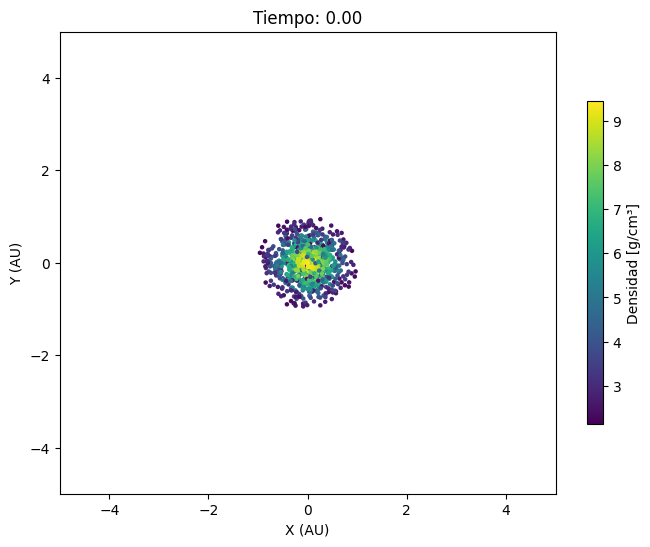

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# Crear un mapa de colores con rango dinámico para la densidad
scatter = None
cbar = None  # Barra de color global

def update(frame):
    global scatter, cbar
    ax.clear()
    ax.set_xlim(-5, 5)  # Ajusta los límites según el sistema
    ax.set_ylim(-5, 5)
    ax.set_title(f"Tiempo: {frame * TIME_STEP:.2f}")
    ax.set_xlabel("X (AU)")
    ax.set_ylabel("Y (AU)")

    # Proyectar posiciones al plano XY
    pos = positions_over_time
    dens = densities_over_time[frame, :]

    # Crear el scatter plot con densidades
    #scatter = ax.scatter(pos[:, 0, frame], pos[:, 1, frame], c=np.log10(dens), cmap='viridis', s=5)
    scatter = ax.scatter(pos[:, 0, frame], pos[:, 1, frame], c=dens, cmap='viridis', s=5)


    # Crear la barra de color solo una vez
    if cbar is None:
        cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.7)
        cbar.set_label("Densidad [g/cm³]") # Ajusta según las unidades de densidad

    return scatter

# Configurar la animación
ani = FuncAnimation(fig, update, frames=len(densities_over_time), interval=50)
writer = PillowWriter(fps=20)
ani.save("density_simulation_with_colorbar.gif", writer=writer)
